In [15]:
import h5py
import numpy as onp
from itertools import starmap
from jax import numpy as jnp
import jax

In [27]:
with h5py.File('test.h5', 'w', libver='latest') as f:
    d = f.create_dataset("detpth_clouds", (10,), maxshape=(None,), dtype="f4")
    d[:10] = onp.random.random((10,)).astype(onp.float32)
    
with h5py.File('test.h5', 'r', libver='latest') as g:
    print(g['detpth_clouds'][:])

[0.94621754 0.4579146  0.74511296 0.92403305 0.8768172  0.40708116
 0.4978676  0.77904266 0.6293515  0.80934733]


In [17]:
def load_databases(f):
    return map(lambda x: f[x], ['masks', 'rgb_clouds', 'depth_clouds', 'labels'])

In [24]:
MAX_SIZE = 2000
def create_datasets(h5py_file):
    f = h5py_file
    masks = f.create_dataset(
        "masks",
        (10**1, MAX_SIZE),
        maxshape=(None, MAX_SIZE),
        dtype="i1",
        chunks=(10**2, MAX_SIZE),
    )
    rgb_clouds = f.create_dataset(
        "rgb_clouds",
        (10**1, 3, MAX_SIZE),
        maxshape=(None, 3, MAX_SIZE),
        dtype="i1",
        chunks=(10**2, 3, MAX_SIZE),
    )
    depth_clouds = f.create_dataset(
        "depth_clouds",
        (10**1, 3, MAX_SIZE),
        maxshape=(None, 3, MAX_SIZE),
        dtype="i4",
        chunks=(10**2, 3, MAX_SIZE),
    )
    labels = f.create_dataset(
        "labels", (10**1,), maxshape=(None,), dtype="i1", chunks=(10**2,)
    )
    return masks, rgb_clouds, depth_clouds, labels


def resize_databases(num_extra):
    list(map(
        lambda x: x.resize(x.shape[0] + num_extra, axis=0),
        [depth_db, rgb_db, m_db, labels_db],
    ))


def save_data(depth, rgb, mask, label, save_i):
    if save_i >= depth_db.shape[0]:
        resize_databases(num_extra=20)

    list(starmap(
        lambda db, val: db.__setitem__(save_i, val),
        zip([depth_db, rgb_db, m_db, labels_db], [depth, rgb, mask, label]),
    ))

    save_i += 1
    return save_i

In [18]:
all_m, all_r, all_d, all_l = list(),list(),list(),list()
for i in range(40):
    with h5py.File(f'dist_data/soccer_balls_data_{i}.h5', 'r', libver='latest',swmr=True) as f:
        m_db, rgb_db, depth_db, labels_db = load_databases(f)
        for db_i,l_i in zip([m_db, rgb_db, depth_db, labels_db],
                            [all_m, all_r, all_d, all_l]):
            db_i.id.refresh()

            l_i.append(db_i[:])
masks, rgbs, depth, labels = [onp.concatenate(l_i) for l_i in [all_m, all_r, all_d, all_l]]

In [22]:
masks.shape

(1869840, 2000)

In [21]:
# m_db, rgb_db, depth_db, labels_db  = list(map(lambda x: onp.concatenate(x), [all_m, all_r, all_d, all_l]))
idx = masks[:,0] > 0
print(idx.shape, idx, idx.sum())
m_, rgb_, depth_, labels_ = [x[idx] for x in [masks, rgbs, depth, labels]]

(1869840,) [ True  True  True ... False False False] 1824984


In [25]:
with h5py.File('./soccer_balls_data_final_2.h5', 'w') as f:
    m_db, rgb_db, depth_db, labels_db = create_datasets(f)
    resize_databases(m_.shape[0] - m_db.shape[0])
    for db, a in zip([m_db, rgb_db, depth_db, labels_db],[m_, rgb_, depth_, labels_]):
        db[:] = a

In [6]:
from train_transformer import binary_auc
import jax
y_hat = jax.random.uniform(jax.random.PRNGKey(10),(4,))
y_labels = jax.random.uniform(jax.random.PRNGKey(1224),(4,))>0.7

auc = binary_auc(y_hat,y_labels[:,None])
# pos = y_hat[y_labels == 1]
# neg = y_hat[y_labels == 0]
# print(pos,neg)
# s = 0
# for p in pos:
#     for n in neg:
#         s+= p>n
# s/(y_labels.sum() * (1-y_labels).sum()), 
auc, y_labels, y_hat


(DeviceArray(0.5, dtype=float32),
 DeviceArray([False, False,  True,  True], dtype=bool),
 DeviceArray([0.91102946, 0.00737166, 0.28678894, 0.8808267 ], dtype=float32))

In [100]:
from dataclasses import replace
cfg = TransformerConfig()
d = {**cfg.__dict__}.update({'deterministic': True})
d = replace(cfg,**{"deterministic":True})
d, cfg

(TransformerConfig(num_heads=4, num_enc_layers=1, num_dec_layers=1, dropout_rate=0.1, deterministic=True, d_model=40, add_positional_encoding=False, max_len=2000, obs_emb_hidden_sizes=(100,), num_latents=1),
 TransformerConfig(num_heads=4, num_enc_layers=1, num_dec_layers=1, dropout_rate=0.1, deterministic=False, d_model=40, add_positional_encoding=False, max_len=2000, obs_emb_hidden_sizes=(100,), num_latents=1))

In [42]:
lines = text.splitlines()
num_steps_idx = [i for i in range(len(lines)) if 'num_steps' in lines[i]]
num_steps_lines = [lines[i] for i in num_steps_idx]
centroid_lines = [lines[i+1] for i in num_steps_idx]
all_num_steps = [float(l.replace("num_steps ", '')) for l in num_steps_lines]
all_centroids = [float(l.replace("centroid ", '')) for l in centroid_lines]

In [28]:
for i in range(1,int(max(all_num_steps))+1):
    num_els = len([ns for ns in all_num_steps if int(ns) == i])
    print(i,num_els)

1 2
2 38
3 54
4 95
5 91
6 44
7 2
8 0
9 0
10 1


<AxesSubplot:ylabel='Frequency'>

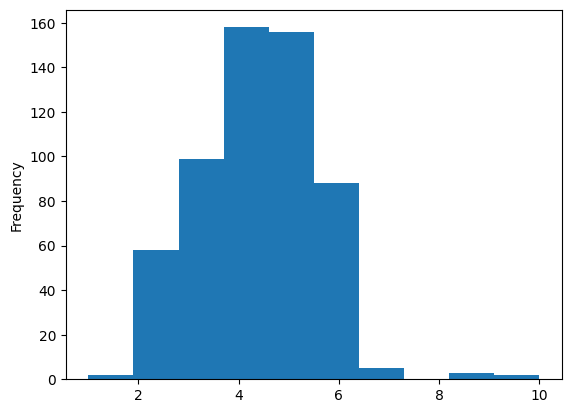

In [68]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
# plt.figure()
data = pd.DataFrame(dict(centroids = all_centroids, num_steps = all_num_steps))
# data = data.loc[(data.num_steps <= 8) & (data.num_steps > 1)]
# data = data.pivot(columns='num_steps', values='centroids')
data.num_steps.plot.hist()
# for i in range(1,7):
#     # _, ax = plt.subplots()
#     df = data.loc[(data.num_steps == i)]
#     # df.centroids.plot.density(ax=ax)
#     df.centroids.plot.density()
# plt.show()
# data.centroids.plot.density()
# data.centroids.min(),data.centroids.max()
# plt.scatter(all_num_steps, all_centroids)
# sns.kdeplot(x=all_centroids, fill=True, common_norm=False, alpha=0.4)